In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from pkgs import *

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [ ]:
train_data, test_data, test_loader = {}, {}, {}
for worker in client_list:
    train_data[worker] = pd.read_csv("data/dataset_{}.csv".format(worker))
df = pd.concat(train_data.values())

In [ ]:
sns.histplot(df['y'].values,bins=100)

In [ ]:
data, label = {"test":{},"train":{},"val":{}}, {"test":{},"train":{},"val":{}}

In [ ]:
for worker in client_list:
    df = train_data[worker].sample(frac=0.1, random_state=0)
    data["test"][worker] = torch.tensor(df[['x' + str(i) for i in range(2048)]].values).float().to(device)
    label["test"][worker] = torch.tensor(df['y'].values).float().to(device).view(-1, 1)
    df = train_data[worker].drop(df.index)
    train = df.sample(frac=0.9, random_state=0)
    val = df.drop(train.index)
    data["train"][worker] = torch.tensor(train[['x' + str(i) for i in range(2048)]].values).float().to(device)
    label["train"][worker] = torch.tensor(train['y'].values).float().to(device).view(-1, 1)
    data["val"][worker] = torch.tensor(val[['x' + str(i) for i in range(2048)]].values).float().to(device)
    label["val"][worker] = torch.tensor(val['y'].values).float().to(device).view(-1, 1)   
    

In [ ]:
model1 = BayesNet()
model1.load_state_dict(torch.load("/home/chengziqiang/project/bayes/result/v0.1/train/model/traditional_abcd.pt"))
model1.to(device)

In [ ]:
model2 = Net()
model2.load_state_dict(torch.load("/home/chengziqiang/project/PySyft/8.2/model/onlyabcd_radio0.9_none_seed1.pt"))
# model2.load_state_dict(torch.load("/home/chengziqiang/project/PySyft/1.4/model/degree_abcd_every5_radio0.9_none_seed1.pt"))

model2.to(device)

In [ ]:
t, worker = "train", "d"

In [ ]:
model3 = BayesNet()
model3.load_state_dict(torch.load("/home/chengziqiang/project/bayes/result/v0.11/train/model/federated_abcd_every1:{}.pt".format(worker)))
model3.to(device)

In [ ]:
pred1 = model1(data[t][worker])
pred2 = model2(data[t][worker])
pred3 = model3(data[t][worker])


In [ ]:
sample_num = 500
model3.eval()
model3.sample()
uncertain = []
for _ in range(sample_num):
    pred = model3(data[t][worker])
    uncertain.append(pred.detach().cpu().numpy())
uncertain = np.concatenate(uncertain,axis=1)
model3.sample(False)
pred = model3(data[t][worker])
loss = F.mse_loss(pred, label[t][worker], reduction="none")
# var = np.square(uncertain - uncertain.mean(axis=1).reshape(-1,1))
var = np.square(uncertain - pred.detach().cpu().numpy().reshape(-1,1))

uncertain.shape
print(pearsonr(uncertain.mean(axis=1).reshape(-1)-label[t][worker].cpu().numpy().reshape(-1).astype("float64"),var.mean(axis=1).reshape(-1).astype("float64")))


print(pearsonr(loss.detach().cpu().numpy().reshape(-1).astype("float64"), var.mean(axis=1).reshape(-1).astype("float64")))


In [ ]:
uncertain[:2,:10]



In [ ]:
uncertain.mean(axis=1)[:2]


In [ ]:
pred.detach().cpu().numpy().reshape(-1,1)[:2]

In [ ]:
d = pd.DataFrame(np.concatenate((np.square(uncertain - uncertain.mean(axis=1).reshape(-1,1)).mean(axis=1).reshape(-1,1),loss.detach().cpu().numpy()),axis=1),columns=["var", "loss"])

In [ ]:
sns.jointplot(d["var"], d["loss"], kind="kde", color="#4CB391")

In [ ]:
sns.jointplot(d["var"], d["loss"], kind="kde", color="#4CB391")

In [ ]:
d["var"].shape

In [ ]:
sns.jointplot(d["var"], d["loss"], kind="kde", color="#4CB391")

In [ ]:
sns.jointplot(d["var"], d["loss"], kind="kde", color="#4CB391")

In [ ]:
d.corr("spearman")


In [ ]:
df = pd.DataFrame(np.concatenate((pred1.detach().cpu().numpy(),label[t][worker].cpu().numpy()),axis = 1),columns=["pred","label"])
sns.scatterplot(x="label", y="pred", data=df)

In [ ]:
df = pd.DataFrame(np.concatenate((pred2.detach().cpu().numpy(),label[t][worker].cpu().numpy()),axis = 1),columns=["pred","label"])
sns.scatterplot(x="label", y="pred", data=df)

In [ ]:
df = pd.DataFrame(np.concatenate((pred3.detach().cpu().numpy(),label[t][worker].cpu().numpy()),axis = 1),columns=["pred","label"])
sns.scatterplot(x="label", y="pred", data=df)

In [ ]:
model1.eval()
for worker in map(lambda x:chr(97+x),range(9)):
    t = pd.read_csv("data/dataset_{}.csv".format(worker)).sample(frac=0.1, random_state=0)
    test_data = torch.tensor(t[['x' + str(i) for i in range(2048)]].values).float().to(device)
    test_label = torch.tensor(t['y'].values).float().to(device).view(-1, 1)
    pred = model1(test_data)
    loss = F.mse_loss(pred, test_label,)
    print(f"{worker}:{loss.detach().cpu().numpy()}r2_score:{r2_score(pred.detach().cpu().numpy(),test_label.cpu().numpy())}")

In [ ]:
# test_data, test_label= {}, {}
model2.eval()
for worker in map(lambda x:chr(97+x),range(9)):
    t = pd.read_csv("data/dataset_{}.csv".format(worker)).sample(frac=0.1, random_state=0)
    test_data = torch.tensor(t[['x' + str(i) for i in range(2048)]].values).float().to(device)
    test_label = torch.tensor(t['y'].values).float().to(device).view(-1, 1)
    pred = model2(test_data)
    loss = F.mse_loss(pred, test_label,)
    print(f"{worker}:{loss.detach().cpu().numpy()}r2_score:{r2_score(pred.detach().cpu().numpy(),test_label.cpu().numpy())}")
    

In [ ]:
model3.eval()
for worker in map(lambda x:chr(97+x),range(9)):
    t = pd.read_csv("data/dataset_{}.csv".format(worker)).sample(frac=0.1, random_state=0)
    test_data = torch.tensor(t[['x' + str(i) for i in range(2048)]].values).float().to(device)
    test_label = torch.tensor(t['y'].values).float().to(device).view(-1, 1)
    pred = model3(test_data)
    loss = F.mse_loss(pred, test_label,)
    print(f"{worker}:{loss.detach().cpu().numpy()}r2_score:{r2_score(pred.detach().cpu().numpy(),test_label.cpu().numpy())}")

    

In [ ]:
model3.eval()
model3.sample()
sample_num = 20
for worker in map(lambda x:chr(97+x),range(9)):
    uncertain = []
    for _ in range(sample_num):
        t = pd.read_csv("data/dataset_{}.csv".format(worker)).sample(frac=0.1, random_state=0)
        test_data = torch.tensor(t[['x' + str(i) for i in range(2048)]].values).float().to(device)
        test_label = torch.tensor(t['y'].values).float().to(device).view(-1, 1)
        pred = model3(test_data)
        uncertain.append(pred.detach().cpu().numpy())
    uncertain = np.concatenate(uncertain,axis=1)
    print(np.square(uncertain - uncertain.mean(axis=1).reshape(-1,1)).mean())
    

In [ ]:
import random
a1 = np.random.rand(500)

random.shuffle(a1)

b1 = np.array([a1[i]/2+1 for i in range(len(a1))])

pearsonr(a1,b1)
d1 = pd.DataFrame(np.concatenate((a1.reshape(-1,1),b1.reshape(-1,1)),axis= 1),columns=["a","b"] )

In [ ]:

sns.jointplot(d1["a"],d1["b"], kind="kde", color="#4CB391")

In [ ]:
def toy_function(x):
    return -x**4 + 3*x**2 + 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from pkgs import *
from torch.distributions import Normal
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [2]:
class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)
class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(1,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x))
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0])
        log_priors = torch.zeros(samples)
        log_posts = torch.zeros(samples)
        log_likes = torch.zeros(samples)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss


In [3]:
def toy_function(x, noisy=0):
    return x + np.sin(2*np.pi*(x+noisy)) +   np.sin(4*np.pi*(x+noisy)) + noisy

In [4]:
np.random.seed(0)
data_x = np.random.rand(100).astype("float32")  / 2
noisy = np.random.normal(100) /100
data_y = data_x + 0.3 * np.sin(2*np.pi*(data_x+noisy)) + 0.3 * np.sin(4*np.pi*(data_x+noisy)) + noisy
data_x = data_x.reshape(-1,1)
data_y = data_y.reshape(-1,1)
data_y = toy_function(data_x)

data_x = torch.Tensor(data_x).to(device)
data_y = torch.Tensor(data_y).to(device)
trainloader = DataLoader(TensorDataset(data_x, data_y),  batch_size=50, shuffle=True)
val_x = np.random.rand(100) / 2
noisy = np.random.normal(100) /100
val_y = val_x + 0.3 * np.sin(2*np.pi*(val_x+noisy)) + 0.3 * np.sin(4*np.pi*(val_x+noisy)) + noisy
val_x = val_x.reshape(-1,1)
val_y = val_y.reshape(-1,1)
val_y = toy_function(val_x)
val_x = torch.Tensor(val_x).to(device)
val_y = torch.Tensor(val_y).to(device)
valloader = DataLoader(TensorDataset(val_x, val_y),  batch_size=50, shuffle=True)
# optimizer = torch.optim.SGD(params=toy.parameters(), lr=0.002, momentum=0.4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, min_lr=0.001)
sample_nums = 30
epoch = 50


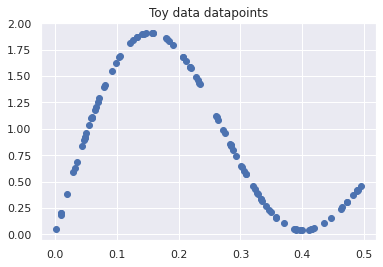

In [5]:
plt.scatter(data_x, data_y)
plt.title('Toy data datapoints')
plt.show()

In [6]:
%%time
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# net = MLP_BBB(32, prior_var=10).to(device)
net = ToyNetL(funcName="Sigmoid", noise_tol=1., prior_var=10., a=.0, b=2).to(device)
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=.1)
# optimizer = torch.optim.SGD(net.parameters(), lr=.1)

epochs = 5000
for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    log_prior, log_post, log_like, outputs = net.sample_elbo(input=data_x, target=data_y, samples=1)
    loss = log_post - log_prior - log_like
#     loss =  net.sample_elbo(input=data_x, target=data_y, samples=1)
    loss.backward()
    nn.utils.clip_grad_norm_(net.parameters(), 5)
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch+1,epochs))
        print('Loss:', loss.item())
print('Finished Training')


33.064208984375
epoch: 171/5000
Loss: 1424.0604248046875
epoch: 181/5000
Loss: 522.9802856445312
epoch: 191/5000
Loss: 1277.613525390625
epoch: 201/5000
Loss: 514.1050415039062
epoch: 211/5000
Loss: 783.777587890625
epoch: 221/5000
Loss: 576.9378051757812
epoch: 231/5000
Loss: 316.7170715332031
epoch: 241/5000
Loss: 111.41737365722656
epoch: 251/5000
Loss: 126.45218658447266
epoch: 261/5000
Loss: 122.16728210449219
epoch: 271/5000
Loss: 120.03290557861328
epoch: 281/5000
Loss: 109.58943939208984
epoch: 291/5000
Loss: 115.8744888305664
epoch: 301/5000
Loss: 140.8559112548828
epoch: 311/5000
Loss: 209.38919067382812
epoch: 321/5000
Loss: 146.28536987304688
epoch: 331/5000
Loss: 342.5588073730469
epoch: 341/5000
Loss: 111.91626739501953
epoch: 351/5000
Loss: 236.7215576171875
epoch: 361/5000
Loss: 106.9165267944336
epoch: 371/5000
Loss: 107.81449890136719
epoch: 381/5000
Loss: 146.8907470703125
epoch: 391/5000
Loss: 104.17723083496094
epoch: 401/5000
Loss: 101.5611343383789
epoch: 411/500

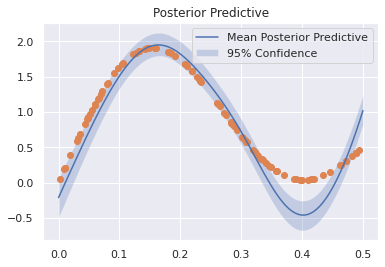

In [9]:
samples = 100
# net.sample()
net.eval()
x_tmp = torch.linspace(0,0.5,100).reshape(-1,1)
y_samp = np.zeros((samples,100))
for s in range(samples):
    y_tmp = net(x_tmp).detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(data_x,data_y)
plt.title('Posterior Predictive')
plt.show()

In [11]:
%%time
for epoch in range(5000):
    losses = []
    toy.train()
#     for data, label in trainloader:
    for _ in range(1):
        pred = toy(data_x)
        loss_likehood = F.mse_loss(data_y, pred) 
        loss_prior = toy.log_prior() 
        loss_posterior = toy.log_post() 
        loss_sum = (loss_likehood - loss_prior + loss_posterior) / sample_nums
#             loss_sum = loss_likehood
        loss_sum.backward()
#             losses.append(loss_sum.detach().cpu().numpy())
        losses.append(list(map(lambda x: x.data.cpu().numpy(), [loss_likehood, -loss_prior, loss_posterior])))
    nn.utils.clip_grad_norm_(toy.parameters(), 5)
    optimizer.step()
    optimizer.zero_grad()
    losses = np.array(losses).mean(axis=0)
#     toy.eval()
# #     for batch_num, (data, label) in enumerate(valloader):
#     pred = toy(val_x)
#     loss = F.mse_loss(val_y, pred, reduction='mean')
    print(epoch, losses.mean(), losses[0], losses[1], losses[2], f"val_loss: {losses.mean()}" )
#     print(epoch, losses.mean(), f"val_loss: {loss}" )
    

0 10.655986 0.07501312 104.49652 -72.60358 val_loss: 10.655985832214355
1 11.304891 0.03229191 101.18956 -67.30718 val_loss: 11.304890632629395
2 11.7914 0.04002198 104.603165 -69.26899 val_loss: 11.791399955749512
3 11.298134 0.03702074 101.60143 -67.74405 val_loss: 11.298133850097656
4 11.10154 0.053313788 100.82206 -67.570755 val_loss: 11.101539611816406
5 11.233223 0.07825602 101.85019 -68.228775 val_loss: 11.233222961425781
6 11.650624 0.04439281 103.87764 -68.97016 val_loss: 11.65062427520752
7 9.646706 0.038961153 106.02141 -77.120255 val_loss: 9.646705627441406
8 12.091268 0.057546627 103.97743 -67.76118 val_loss: 12.091267585754395
9 11.971538 0.07357476 106.21414 -70.37311 val_loss: 11.971537590026855
10 12.528046 0.09744358 107.53442 -70.04772 val_loss: 12.528045654296875
11 11.632823 0.054038998 99.36257 -64.51814 val_loss: 11.63282299041748
12 11.69781 0.47582072 102.56066 -67.943054 val_loss: 11.697810173034668
13 10.470586 0.09737785 101.539024 -70.22465 val_loss: 10.470

147 10.755852 0.37841222 105.01233 -73.123184 val_loss: 10.755851745605469
148 10.4954195 0.033394273 107.7305 -76.27763 val_loss: 10.4954195022583
149 9.522611 0.037998434 105.73314 -77.20331 val_loss: 9.522610664367676
150 9.363584 0.08867727 100.251335 -72.24926 val_loss: 9.3635835647583
151 11.01619 0.112366915 102.71975 -69.78355 val_loss: 11.016189575195312
152 10.601936 0.12427432 97.97508 -66.29355 val_loss: 10.601936340332031
153 11.268834 0.04402461 103.410515 -69.64803 val_loss: 11.268834114074707
154 11.99602 0.03636523 102.95731 -67.005615 val_loss: 11.996020317077637
155 11.33786 0.057118054 99.263145 -65.30669 val_loss: 11.337860107421875
156 10.537265 0.045105673 102.50481 -70.93812 val_loss: 10.537264823913574
157 11.078097 0.045848843 102.623184 -69.43474 val_loss: 11.078097343444824
158 10.956032 0.05666316 104.618965 -71.80753 val_loss: 10.956031799316406
159 12.626567 0.06868392 100.32885 -62.517838 val_loss: 12.626566886901855
160 11.285108 0.060638048 101.57658 -

283 12.200114 0.090461396 103.83338 -67.3235 val_loss: 12.200114250183105
284 11.006497 0.5368749 101.055695 -68.573074 val_loss: 11.006497383117676
285 9.643529 0.7678631 105.22646 -77.063736 val_loss: 9.643528938293457
286 10.554624 0.039165366 99.77524 -68.15053 val_loss: 10.5546236038208
287 11.767136 0.06330674 102.19541 -66.95731 val_loss: 11.767135620117188
288 11.313708 0.042496733 108.16574 -74.26711 val_loss: 11.313708305358887
289 9.354106 0.05192236 106.69531 -78.68492 val_loss: 9.354105949401855
290 9.897128 0.060492367 99.752686 -70.121796 val_loss: 9.897128105163574
291 11.1863785 0.0547711 104.15805 -70.65369 val_loss: 11.186378479003906
292 11.331604 0.05544116 101.61186 -67.67249 val_loss: 11.33160400390625
293 10.891284 0.0380501 103.606445 -70.97064 val_loss: 10.891283988952637
294 10.74657 0.21857518 100.67078 -68.64964 val_loss: 10.746569633483887
295 10.835266 0.5313858 101.14432 -69.16991 val_loss: 10.83526611328125
296 10.291112 0.056341477 103.450836 -72.63384

433 13.111302 0.055093907 106.50658 -67.22776 val_loss: 13.111302375793457
434 10.8699465 0.06428462 108.94218 -76.39662 val_loss: 10.869946479797363
435 10.583611 0.9631911 99.60594 -68.8183 val_loss: 10.583610534667969
436 11.655278 1.0222464 100.87442 -66.93083 val_loss: 11.655278205871582
437 10.043694 0.19560723 103.79738 -73.86191 val_loss: 10.043693542480469
438 10.956805 0.08453516 100.97881 -68.19293 val_loss: 10.956805229187012
439 10.3189745 0.046838302 108.89815 -77.98806 val_loss: 10.318974494934082
440 10.287849 0.9237114 114.57263 -84.6328 val_loss: 10.287849426269531
441 12.271996 0.049872674 104.88927 -68.12315 val_loss: 12.271995544433594
442 9.138939 2.8253741 108.65666 -84.065216 val_loss: 9.138938903808594
443 9.095883 0.101755574 108.6402 -81.4543 val_loss: 9.0958833694458
444 11.37749 0.058012553 105.28175 -71.2073 val_loss: 11.377490043640137
445 9.769554 0.05918615 102.42603 -73.17656 val_loss: 9.769554138183594
446 8.855578 0.04388659 97.862526 -71.339676 val_

587 11.384865 0.05311177 101.43371 -67.33222 val_loss: 11.384864807128906
588 11.244 0.06791325 105.2745 -71.61041 val_loss: 11.244000434875488
589 9.211761 0.03545873 101.30876 -73.70894 val_loss: 9.211761474609375
590 11.623895 0.05602385 98.61607 -63.80041 val_loss: 11.623894691467285
591 11.725792 0.06781535 101.73505 -66.62549 val_loss: 11.725791931152344
592 9.978587 0.042275187 99.811615 -69.91813 val_loss: 9.97858715057373
593 12.476544 0.048162736 101.281075 -63.899605 val_loss: 12.476544380187988
594 11.085277 0.044850893 100.638176 -67.4272 val_loss: 11.08527660369873
595 10.444041 0.040101305 105.663605 -74.37158 val_loss: 10.44404125213623
596 10.92525 0.0321841 101.45444 -68.71087 val_loss: 10.925250053405762
597 13.233851 0.04349971 104.37276 -64.71471 val_loss: 13.233851432800293
598 10.186765 0.05930187 97.231155 -66.73016 val_loss: 10.18676471710205
599 11.262698 0.047227547 102.44095 -68.70008 val_loss: 11.26269817352295
600 9.999316 0.07064611 104.5981 -74.6708 val_

731 10.545181 0.7245929 106.5809 -75.66995 val_loss: 10.545181274414062
732 9.976646 0.07566249 103.69473 -73.840454 val_loss: 9.976646423339844
733 7.87382 0.1971384 109.66087 -86.23655 val_loss: 7.873819828033447
734 11.739037 0.058995966 100.29239 -65.13428 val_loss: 11.739036560058594
735 10.50222 0.04033027 103.726006 -72.259674 val_loss: 10.502220153808594
736 10.302559 0.06242002 103.554054 -72.7088 val_loss: 10.302558898925781
737 10.823067 0.042734876 100.96268 -68.53621 val_loss: 10.823066711425781
738 10.069191 0.06516737 100.80731 -70.66491 val_loss: 10.069190979003906
739 11.004046 1.5461197 102.70169 -71.23567 val_loss: 11.004046440124512
740 12.470767 0.08165687 100.8052 -63.474556 val_loss: 12.4707670211792
741 11.076653 0.06815686 106.66884 -73.507034 val_loss: 11.076652526855469
742 11.570706 0.07913143 103.2282 -68.595215 val_loss: 11.570706367492676
743 10.958905 0.08402723 102.33604 -69.54335 val_loss: 10.958905220031738
744 9.935496 0.07156357 104.278404 -74.54348

876 10.278302 0.09836503 105.81823 -75.08169 val_loss: 10.278302192687988
877 8.9948 0.720832 102.61615 -76.352585 val_loss: 8.994799613952637
878 10.92942 0.09324039 100.81935 -68.12433 val_loss: 10.929420471191406
879 10.342267 0.21796331 109.003265 -78.19443 val_loss: 10.342267036437988
880 10.939326 0.03807567 107.61725 -74.83735 val_loss: 10.939326286315918
881 9.945111 0.8815372 99.341675 -70.38788 val_loss: 9.945111274719238
882 10.260854 0.062043443 99.83954 -69.11902 val_loss: 10.26085376739502
883 9.383537 0.19480616 96.62157 -68.665764 val_loss: 9.383537292480469
884 11.204727 0.0668984 97.752495 -64.205215 val_loss: 11.204727172851562
885 8.775505 0.35846642 99.17979 -73.21174 val_loss: 8.775505065917969
886 11.2630415 0.09812218 109.031296 -75.340294 val_loss: 11.263041496276855
887 10.8847 0.06960459 101.13022 -68.54572 val_loss: 10.884699821472168
888 10.7044525 0.054228123 100.9389 -68.879776 val_loss: 10.704452514648438
889 10.306842 0.13060808 101.645676 -70.85576 val

1021 9.193942 0.17138237 109.33496 -81.924515 val_loss: 9.193942070007324
1022 10.994771 0.085252434 101.0869 -68.187836 val_loss: 10.994771003723145
1023 10.620046 0.053265866 102.303116 -70.49625 val_loss: 10.62004566192627
1024 10.825398 0.093138106 101.97473 -69.591675 val_loss: 10.825398445129395
1025 9.732129 0.07637313 100.94913 -71.82911 val_loss: 9.732129096984863
1026 10.07108 0.12047991 103.85984 -73.76708 val_loss: 10.071080207824707
1027 9.778854 0.0662384 98.456055 -69.18573 val_loss: 9.778854370117188
1028 11.498652 0.09479632 97.06535 -62.664192 val_loss: 11.498652458190918
1029 10.505757 0.062041115 99.32193 -67.8667 val_loss: 10.505757331848145
1030 9.435539 0.039589774 103.837296 -75.57027 val_loss: 9.435539245605469
1031 11.894638 0.119261704 103.88468 -68.32003 val_loss: 11.894638061523438
1032 11.1238785 0.06386938 107.061264 -73.753494 val_loss: 11.123878479003906
1033 11.019768 0.098809354 97.936325 -64.97583 val_loss: 11.019767761230469
1034 9.195839 0.51172066

1159 10.498158 0.051741853 103.06517 -71.62244 val_loss: 10.49815845489502
1160 11.441322 0.04206676 97.74631 -63.46441 val_loss: 11.441322326660156
1161 8.286283 0.17569073 104.07124 -79.388084 val_loss: 8.286282539367676
1162 11.846725 0.06739219 102.16834 -66.69556 val_loss: 11.846725463867188
1163 10.154012 0.16627435 97.9607 -67.66494 val_loss: 10.154011726379395
1164 11.783313 0.055574592 102.75155 -67.457184 val_loss: 11.783312797546387
1165 9.721255 0.11726126 101.620346 -72.573845 val_loss: 9.7212553024292
1166 9.941933 0.070493974 106.21889 -76.463585 val_loss: 9.941932678222656
1167 11.337326 0.10647254 102.804794 -68.89929 val_loss: 11.337326049804688
1168 11.407002 5.053413 105.40758 -76.23998 val_loss: 11.407002449035645
1169 8.967944 0.06748697 100.05686 -73.22052 val_loss: 8.967944145202637
1170 12.123965 0.06755193 102.3336 -66.02926 val_loss: 12.1239652633667
1171 8.737134 0.0540399 109.6237 -83.46634 val_loss: 8.737133979797363
1172 11.683507 0.09181516 101.98439 -67

1306 11.466281 0.06764794 100.774704 -66.44351 val_loss: 11.466280937194824
1307 9.196467 0.04441062 100.02936 -72.48437 val_loss: 9.196467399597168
1308 9.927943 0.29446712 101.540085 -72.05072 val_loss: 9.927943229675293
1309 11.036606 0.16446668 94.92982 -61.984467 val_loss: 11.036605834960938
1310 11.086784 0.083168 106.25206 -73.074875 val_loss: 11.086784362792969
1311 9.038467 0.07578975 100.93152 -73.89191 val_loss: 9.038467407226562
1312 10.825877 0.7200778 103.51599 -71.75844 val_loss: 10.82587718963623
1313 8.694051 0.06946258 101.18722 -75.17453 val_loss: 8.694050788879395
1314 9.930425 0.046942443 103.1701 -73.425766 val_loss: 9.930424690246582
1315 10.138125 0.08170574 99.4801 -69.14743 val_loss: 10.1381254196167
1316 10.682796 0.03732243 103.84733 -71.836266 val_loss: 10.682795524597168
1317 11.137601 0.036526233 97.62859 -64.25232 val_loss: 11.137600898742676
1318 9.274742 0.13915163 97.52246 -69.83739 val_loss: 9.274742126464844
1319 11.427612 0.11096287 100.09355 -65.9

1460 9.865216 0.25283414 100.62723 -71.28441 val_loss: 9.865216255187988
1461 10.907588 0.050578956 100.23219 -67.560005 val_loss: 10.907588005065918
1462 9.988927 0.07834946 103.79242 -73.903984 val_loss: 9.988926887512207
1463 8.714808 0.45962062 104.29496 -78.61015 val_loss: 8.714808464050293
1464 10.511233 0.115576565 100.946396 -69.528275 val_loss: 10.51123332977295
1465 8.673953 0.13528231 103.60588 -77.71931 val_loss: 8.67395305633545
1466 11.176938 0.058504358 101.292076 -67.81976 val_loss: 11.1769380569458
1467 13.10907 0.06421263 98.1532 -58.890198 val_loss: 13.10906982421875
1468 9.849808 0.0798959 104.278534 -74.809006 val_loss: 9.849807739257812
1469 11.096484 0.042320594 97.34218 -64.09505 val_loss: 11.096484184265137
1470 10.929077 0.13210434 100.11693 -67.4618 val_loss: 10.9290771484375
1471 11.612498 0.055316374 98.56085 -63.77867 val_loss: 11.61249828338623
1472 8.07323 0.035329483 105.46797 -81.283615 val_loss: 8.073229789733887
1473 9.873741 0.19896503 100.231766 -7

1612 11.157292 0.08642147 109.503624 -76.118164 val_loss: 11.157292366027832
1613 11.582189 0.08501694 106.85991 -72.19836 val_loss: 11.582188606262207
1614 10.860397 0.0668592 104.11913 -71.6048 val_loss: 10.860397338867188
1615 9.163658 0.16859634 99.70462 -72.38224 val_loss: 9.163658142089844
1616 9.476871 0.050916485 103.55052 -75.17083 val_loss: 9.4768705368042
1617 9.772365 0.06528041 101.53438 -72.28256 val_loss: 9.772364616394043
1618 10.145938 0.18853691 104.995735 -74.74646 val_loss: 10.1459379196167
1619 9.26382 0.37019357 96.08682 -68.66556 val_loss: 9.263819694519043
1620 9.49218 0.18034779 105.2296 -76.93341 val_loss: 9.492179870605469
1621 9.739362 0.771611 104.34596 -75.89949 val_loss: 9.739361763000488
1622 8.806068 0.06682349 101.41464 -75.06326 val_loss: 8.806068420410156
1623 9.029289 0.1621284 105.047226 -78.12148 val_loss: 9.029289245605469
1624 8.361211 0.04250298 97.8636 -72.82247 val_loss: 8.361210823059082
1625 8.832393 0.051857024 100.00973 -73.56441 val_loss

1763 9.203865 0.14054552 99.804565 -72.33352 val_loss: 9.203865051269531
1764 10.208867 0.06527952 100.76555 -70.20422 val_loss: 10.208867073059082
1765 11.228177 0.06138749 102.154594 -68.53145 val_loss: 11.228177070617676
1766 10.115753 0.14827448 99.54943 -69.35045 val_loss: 10.115753173828125
1767 10.08343 0.099891074 103.021774 -72.871376 val_loss: 10.083430290222168
1768 10.63578 0.04876041 102.708755 -70.850174 val_loss: 10.635780334472656
1769 11.170563 0.047906335 99.831375 -66.36759 val_loss: 11.170562744140625
1770 10.333844 0.09563488 97.58551 -66.67961 val_loss: 10.333844184875488
1771 10.20538 0.2791598 100.37313 -70.03615 val_loss: 10.2053804397583
1772 10.34742 0.15390708 95.56269 -64.67434 val_loss: 10.347419738769531
1773 9.525363 0.035535168 103.231 -74.69045 val_loss: 9.525362968444824
1774 10.300766 0.54516 97.89611 -67.53897 val_loss: 10.300765991210938
1775 10.159836 0.093986005 97.25273 -66.86721 val_loss: 10.159835815429688
1776 10.243381 0.039647225 103.48732 

1909 8.605901 0.108065 101.24226 -75.53262 val_loss: 8.605900764465332
1910 10.225838 0.29054278 104.86427 -74.4773 val_loss: 10.225837707519531
1911 9.098819 2.5580401 102.26533 -77.52691 val_loss: 9.0988187789917
1912 10.078949 0.31402215 102.21376 -72.29094 val_loss: 10.078948974609375
1913 10.689519 0.05841487 108.28261 -76.27247 val_loss: 10.689518928527832
1914 10.54514 0.32424915 101.32446 -70.01329 val_loss: 10.545140266418457
1915 11.053967 0.09604526 100.97896 -67.9131 val_loss: 11.053967475891113
1916 9.592537 0.04172115 93.99743 -65.261536 val_loss: 9.592536926269531
1917 10.155406 0.09052815 102.42244 -72.04675 val_loss: 10.15540599822998
1918 9.153003 0.18298212 100.85885 -73.582825 val_loss: 9.153002738952637
1919 9.344615 0.21306358 95.71329 -67.89251 val_loss: 9.34461498260498
1920 9.59389 0.09238471 102.17545 -73.48617 val_loss: 9.593890190124512
1921 8.783023 1.3851694 102.57468 -77.61078 val_loss: 8.7830228805542
1922 9.499486 0.70204467 101.77925 -73.982834 val_los

2056 10.167096 0.034224823 98.700195 -68.23313 val_loss: 10.167096138000488
2057 10.096664 0.093264 100.21672 -70.01999 val_loss: 10.096664428710938
2058 10.310631 0.19009013 104.929474 -74.18767 val_loss: 10.310630798339844
2059 9.239032 0.05119741 104.44692 -76.78103 val_loss: 9.239031791687012
2060 8.099118 0.39133176 100.3434 -76.43738 val_loss: 8.09911823272705
2061 10.400325 0.16735351 99.200584 -68.16696 val_loss: 10.400324821472168
2062 8.661128 0.094891995 103.71447 -77.82598 val_loss: 8.661128044128418
2063 9.395129 0.31664437 103.24765 -75.37891 val_loss: 9.395129203796387
2064 8.639323 1.1936576 100.90797 -76.183655 val_loss: 8.639323234558105
2065 7.8483505 0.13520713 100.56851 -77.15867 val_loss: 7.848350524902344
2066 10.15227 0.09338114 104.66186 -74.29843 val_loss: 10.152270317077637
2067 9.625328 0.079204455 98.688095 -69.89131 val_loss: 9.625328063964844
2068 10.673924 0.093012296 101.11207 -69.183304 val_loss: 10.673924446105957
2069 9.383306 3.588805 103.12682 -78.

2206 10.4576645 0.5309546 105.49017 -74.64813 val_loss: 10.457664489746094
2207 9.1741 0.058650285 103.29207 -75.828415 val_loss: 9.174099922180176
2208 9.810844 0.06710971 97.211296 -67.84587 val_loss: 9.810844421386719
2209 10.164807 0.1823306 100.61615 -70.304054 val_loss: 10.164807319641113
2210 9.754677 0.05504569 104.22189 -75.01291 val_loss: 9.754676818847656
2211 9.621379 0.07361751 100.05693 -71.26641 val_loss: 9.621378898620605
2212 9.847865 0.090997905 105.523636 -76.07104 val_loss: 9.847865104675293
2213 9.234245 0.12194562 99.67589 -72.0951 val_loss: 9.234245300292969
2214 8.756665 0.037243906 94.8502 -68.61745 val_loss: 8.756665229797363
2215 8.632439 0.66978884 101.145515 -75.91799 val_loss: 8.632438659667969
2216 9.421535 0.15136985 98.09186 -69.97862 val_loss: 9.421534538269043
2217 9.334145 0.0706249 106.29579 -78.36398 val_loss: 9.334144592285156
2218 9.802429 0.04008457 100.6409 -71.2737 val_loss: 9.80242919921875
2219 9.734055 0.032683443 102.1774 -73.00792 val_los

2351 9.709427 0.05102471 97.49781 -68.420555 val_loss: 9.709426879882812
2352 9.037837 0.06801531 99.21864 -72.17315 val_loss: 9.037837028503418
2353 10.564771 0.09698138 107.3551 -75.757774 val_loss: 10.564770698547363
2354 8.862269 0.077220105 104.22112 -77.71153 val_loss: 8.862269401550293
2355 9.340424 0.034746908 102.22298 -74.23645 val_loss: 9.340423583984375
2356 10.739789 0.1045672 102.29863 -70.18383 val_loss: 10.739789009094238
2357 10.397255 0.03551347 97.59283 -66.43658 val_loss: 10.397254943847656
2358 9.929584 0.33308992 104.61769 -75.16203 val_loss: 9.929583549499512
2359 9.231117 0.2405106 99.680336 -72.22749 val_loss: 9.231117248535156
2360 10.160321 0.09209718 97.13324 -66.74437 val_loss: 10.160321235656738
2361 9.1886015 0.11084283 100.42095 -72.96599 val_loss: 9.18860149383545
2362 10.552399 0.055213057 98.17216 -66.570175 val_loss: 10.552398681640625
2363 9.624265 0.27775237 105.06967 -76.47463 val_loss: 9.62426471710205
2364 9.428357 0.14021073 101.77307 -73.62821

2501 9.753392 0.06671526 104.54921 -75.35575 val_loss: 9.753392219543457
2502 8.8574295 1.2138743 105.60895 -80.250534 val_loss: 8.857429504394531
2503 9.905681 0.059480295 100.603195 -70.94563 val_loss: 9.905680656433105
2504 9.345589 0.09012403 103.22781 -75.28117 val_loss: 9.345588684082031
2505 8.844157 0.07988751 100.556076 -74.10349 val_loss: 8.844157218933105
2506 9.465935 0.28317174 102.37505 -74.26042 val_loss: 9.465934753417969
2507 9.872684 0.0662498 101.336044 -71.78424 val_loss: 9.87268352508545
2508 10.686691 0.0408128 98.62024 -66.600975 val_loss: 10.686691284179688
2509 8.593776 0.5839308 100.199066 -75.00167 val_loss: 8.593775749206543
2510 8.600955 0.11568588 97.3629 -71.67572 val_loss: 8.60095500946045
2511 9.926132 0.07593874 98.03299 -68.33053 val_loss: 9.926132202148438
2512 8.146983 0.053537253 102.603516 -78.2161 val_loss: 8.14698314666748
2513 10.28257 0.7620311 103.132385 -73.04671 val_loss: 10.282569885253906
2514 9.065804 0.061614893 100.41441 -73.27862 val_

2652 9.727328 0.07639354 99.87724 -70.77165 val_loss: 9.727328300476074
2653 10.222318 0.055258047 101.308815 -70.69712 val_loss: 10.222317695617676
2654 9.794182 0.43908224 102.738205 -73.79474 val_loss: 9.794181823730469
2655 7.267156 1.290663 99.795105 -79.2843 val_loss: 7.26715612411499
2656 8.737953 0.0978535 103.41597 -77.299965 val_loss: 8.737953186035156
2657 8.691963 0.037980877 99.20574 -73.16783 val_loss: 8.691963195800781
2658 10.173363 0.05911194 103.4503 -72.98933 val_loss: 10.173362731933594
2659 9.897537 0.0725641 99.4908 -69.87075 val_loss: 9.897537231445312
2660 8.756813 0.1263913 103.54623 -77.402176 val_loss: 8.756813049316406
2661 9.196915 0.14942533 99.33478 -71.893456 val_loss: 9.196914672851562
2662 9.645549 0.3711383 104.03625 -75.47074 val_loss: 9.645548820495605
2663 9.9784775 0.031144328 94.50646 -64.60217 val_loss: 9.978477478027344
2664 10.077739 0.74261147 97.16325 -67.67265 val_loss: 10.077738761901855
2665 9.059382 0.10313962 104.32589 -77.250885 val_lo

2799 9.976265 0.106835224 100.74782 -70.92586 val_loss: 9.976264953613281
2800 9.003441 0.051660635 99.52902 -72.57036 val_loss: 9.003440856933594
2801 9.046753 0.26245043 98.27363 -71.39582 val_loss: 9.0467529296875
2802 10.287712 0.06631888 103.17682 -72.380005 val_loss: 10.287712097167969
2803 9.118329 0.48675948 98.20322 -71.33499 val_loss: 9.118329048156738
2804 7.011223 0.037355255 106.04131 -85.045 val_loss: 7.011222839355469
2805 9.82619 0.051615216 103.41217 -73.985214 val_loss: 9.826189994812012
2806 9.386502 0.19476196 100.335556 -72.37081 val_loss: 9.386502265930176
2807 9.306808 0.039151825 98.2425 -70.36123 val_loss: 9.306808471679688
2808 10.876683 0.124530554 103.3577 -70.85217 val_loss: 10.876683235168457
2809 10.218219 0.06288495 99.66413 -69.07236 val_loss: 10.218218803405762
2810 8.158409 0.07535934 99.1906 -74.790726 val_loss: 8.158409118652344
2811 9.692332 0.12921645 103.57356 -74.625786 val_loss: 9.69233226776123
2812 9.24159 0.070715345 103.42365 -75.7696 val_l

2951 8.706058 0.6121738 96.534546 -71.02855 val_loss: 8.70605754852295
2952 9.4756975 0.55760866 97.23521 -69.36572 val_loss: 9.47569751739502
2953 8.281987 0.04864271 97.08018 -72.28286 val_loss: 8.281987190246582
2954 9.920192 0.6495201 98.83861 -69.727554 val_loss: 9.920191764831543
2955 9.090627 0.034210347 100.80455 -73.56688 val_loss: 9.09062671661377
2956 9.530548 0.07209157 104.28834 -75.76878 val_loss: 9.530548095703125
2957 9.303172 0.46930137 101.5895 -74.149284 val_loss: 9.30317211151123
2958 8.286763 0.2187966 98.54762 -73.90613 val_loss: 8.286763191223145
2959 7.8555984 0.057825673 103.954926 -80.44595 val_loss: 7.855598449707031
2960 7.412226 0.021776149 106.08313 -83.868225 val_loss: 7.41222620010376
2961 9.712962 0.050897226 102.037445 -72.949455 val_loss: 9.71296215057373
2962 8.873372 0.03752271 97.6496 -71.067 val_loss: 8.873372077941895
2963 9.307663 0.113298155 100.249405 -72.43971 val_loss: 9.307662963867188
2964 7.971433 0.065059416 102.99242 -79.14317 val_loss:

3102 7.6171875 0.26288927 103.91818 -81.329506 val_loss: 7.6171875
3103 9.637715 0.05240719 96.02907 -67.16833 val_loss: 9.637715339660645
3104 9.244281 0.061773982 97.559296 -69.88823 val_loss: 9.244280815124512
3105 8.905711 0.23583128 99.29046 -72.80916 val_loss: 8.90571117401123
3106 9.3667555 0.12162456 103.998825 -76.02019 val_loss: 9.366755485534668
3107 9.745216 0.1302275 99.91832 -70.8129 val_loss: 9.745216369628906
3108 7.369062 0.15832974 98.49631 -76.547455 val_loss: 7.3690619468688965
3109 7.851372 0.2745837 100.670235 -77.3907 val_loss: 7.851371765136719
3110 7.7811637 0.030036455 97.506996 -74.19354 val_loss: 7.781163692474365
3111 8.624878 0.07075737 96.10076 -70.29688 val_loss: 8.6248779296875
3112 7.3915405 0.08624998 101.9362 -79.84783 val_loss: 7.39154052734375
3113 7.783686 0.13826989 99.2186 -76.005806 val_loss: 7.78368616104126
3114 9.03674 0.05887159 98.37738 -71.32603 val_loss: 9.03674030303955
3115 10.145332 0.069514744 97.719864 -67.35338 val_loss: 10.1453323

3244 6.9503784 0.1515316 102.83591 -82.13631 val_loss: 6.95037841796875
3245 10.433774 0.21532466 97.34931 -66.26331 val_loss: 10.4337739944458
3246 8.879308 0.061227635 98.32229 -71.74559 val_loss: 8.879307746887207
3247 8.170064 0.087816164 102.628395 -78.20602 val_loss: 8.170063972473145
3248 7.6036353 0.05570838 99.86294 -77.10774 val_loss: 7.603635311126709
3249 8.154091 0.3564998 100.16446 -76.058685 val_loss: 8.154090881347656
3250 10.104655 0.078207806 95.22794 -64.99219 val_loss: 10.104655265808105
3251 7.451673 0.058435168 100.80513 -78.508545 val_loss: 7.4516730308532715
3252 10.021024 0.0962178 99.90491 -69.93805 val_loss: 10.021023750305176
3253 8.59792 0.18453394 100.756294 -75.147064 val_loss: 8.597920417785645
3254 8.21658 0.058567576 95.55229 -70.96112 val_loss: 8.216580390930176
3255 7.1417313 0.6685643 100.15793 -79.4013 val_loss: 7.141731262207031
3256 8.443568 0.58999085 103.65706 -78.91634 val_loss: 8.443568229675293
3257 9.073006 0.11879526 102.05525 -74.95503 va

3387 8.165141 0.29290774 99.89538 -75.69286 val_loss: 8.165141105651855
3388 8.0826235 3.2475977 103.06558 -82.06531 val_loss: 8.082623481750488
3389 6.3513207 0.22098671 99.78552 -80.952545 val_loss: 6.351320743560791
3390 9.020261 0.50729746 100.29776 -73.74427 val_loss: 9.02026081085205
3391 8.246058 0.06141928 100.69748 -76.02072 val_loss: 8.246058464050293
3392 9.754056 0.1012208 99.94345 -70.7825 val_loss: 9.754055976867676
3393 9.363571 0.08180919 97.61915 -69.610245 val_loss: 9.363571166992188
3394 9.57211 1.4686214 100.13599 -72.888275 val_loss: 9.572110176086426
3395 8.653409 0.107118994 103.84306 -77.98995 val_loss: 8.653409004211426
3396 10.348758 0.048646633 104.94321 -73.94558 val_loss: 10.34875774383545
3397 9.389829 0.19460186 101.61023 -73.635345 val_loss: 9.3898286819458
3398 8.530838 0.40762433 102.96214 -77.77725 val_loss: 8.530838012695312
3399 8.0568285 0.14380473 98.82162 -74.79494 val_loss: 8.056828498840332
3400 9.500026 0.207964 98.224625 -69.93251 val_loss: 9

3536 8.753978 1.1475251 97.81023 -72.695816 val_loss: 8.75397777557373
3537 9.025821 0.37769863 103.03494 -76.33518 val_loss: 9.0258207321167
3538 6.7312903 0.18585193 95.77421 -75.76619 val_loss: 6.731290340423584
3539 6.474459 0.11345711 102.83795 -83.52803 val_loss: 6.474459171295166
3540 7.6606216 0.1769557 98.99826 -76.19335 val_loss: 7.660621643066406
3541 8.603513 0.09065561 105.00433 -79.28445 val_loss: 8.60351276397705
3542 8.71936 0.26545158 98.37332 -72.48069 val_loss: 8.7193603515625
3543 9.039159 0.19060923 101.520584 -74.59372 val_loss: 9.039158821105957
3544 8.71034 0.12471669 99.51846 -73.51216 val_loss: 8.710339546203613
3545 8.718048 0.0998624 98.450356 -72.39607 val_loss: 8.718048095703125
3546 8.369098 0.2518488 97.18986 -72.33441 val_loss: 8.369097709655762
3547 10.549207 0.07448023 96.13102 -64.55788 val_loss: 10.549206733703613
3548 8.659701 1.1360962 97.95479 -73.11178 val_loss: 8.659701347351074
3549 9.446912 0.034410924 97.013336 -68.70701 val_loss: 9.44691181

3686 7.114105 0.03839677 99.39527 -78.091354 val_loss: 7.114105224609375
3687 9.163254 0.2760111 96.19621 -68.98246 val_loss: 9.163253784179688
3688 10.160683 0.1280276 97.04877 -66.69475 val_loss: 10.160682678222656
3689 9.135757 0.14633806 100.592285 -73.33135 val_loss: 9.135757446289062
3690 9.885228 0.111727916 100.0293 -70.48534 val_loss: 9.885228157043457
3691 9.093312 0.1426742 96.19228 -69.05502 val_loss: 9.09331226348877
3692 7.7416816 0.10470011 100.60615 -77.4858 val_loss: 7.7416815757751465
3693 8.465907 0.0921167 103.9807 -78.675095 val_loss: 8.465907096862793
3694 9.276021 0.16322626 96.188866 -68.524025 val_loss: 9.276021003723145
3695 7.0666122 0.30765885 103.53825 -82.64607 val_loss: 7.066612243652344
3696 8.637599 0.081963815 101.25257 -75.42174 val_loss: 8.637598991394043
3697 9.598938 0.10996559 100.97154 -72.28469 val_loss: 9.59893798828125
3698 8.589002 0.16086414 102.78252 -77.17638 val_loss: 8.589001655578613
3699 8.228104 0.13118127 100.68126 -76.12813 val_loss

3832 7.982076 0.0943365 108.35572 -84.50383 val_loss: 7.982076168060303
3833 10.048045 0.5638819 102.50373 -72.92348 val_loss: 10.04804515838623
3834 7.44988 1.2547048 98.06102 -76.96609 val_loss: 7.449880123138428
3835 8.410835 1.8568892 99.65869 -76.28307 val_loss: 8.410835266113281
3836 6.2070413 0.60154045 101.27817 -83.25858 val_loss: 6.207041263580322
3837 9.045662 0.72231835 94.41375 -67.999084 val_loss: 9.045661926269531
3838 8.746524 0.15947002 101.05056 -74.97046 val_loss: 8.7465238571167
3839 9.932813 0.28723973 101.30068 -71.78948 val_loss: 9.932812690734863
3840 8.198552 0.08397679 99.28039 -74.76871 val_loss: 8.198552131652832
3841 9.750511 0.11682569 101.08501 -71.9503 val_loss: 9.750511169433594
3842 8.936096 0.1407789 99.49967 -72.83216 val_loss: 8.93609619140625
3843 6.840912 0.12228231 105.762375 -85.36192 val_loss: 6.840911865234375
3844 9.324367 0.17180248 96.89583 -69.09453 val_loss: 9.324366569519043
3845 8.880699 0.16109866 94.80469 -68.32369 val_loss: 8.8806991

3980 8.848317 1.1974607 95.60901 -70.26152 val_loss: 8.84831714630127
3981 8.56944 0.029178638 96.59826 -70.91912 val_loss: 8.569439888000488
3982 9.224774 0.09072289 100.19031 -72.606705 val_loss: 9.224774360656738
3983 7.635605 0.16169205 98.99365 -76.24853 val_loss: 7.6356048583984375
3984 8.152069 0.06472198 100.37233 -75.98084 val_loss: 8.152069091796875
3985 7.830889 0.1595918 101.700745 -78.36767 val_loss: 7.8308892250061035
3986 5.1123757 0.0671865 101.13333 -85.86339 val_loss: 5.112375736236572
3987 8.686295 0.18572676 98.43311 -72.55996 val_loss: 8.686294555664062
3988 6.940811 0.13229682 97.224014 -76.533875 val_loss: 6.9408111572265625
3989 8.088094 0.6452543 96.894554 -73.27553 val_loss: 8.088093757629395
3990 6.376722 0.8314998 98.78979 -80.49112 val_loss: 6.3767218589782715
3991 6.013453 0.05853226 102.03929 -84.057465 val_loss: 6.013453006744385
3992 9.109059 0.06504855 94.72073 -67.4586 val_loss: 9.10905933380127
3993 9.28083 0.051467575 96.91243 -69.12141 val_loss: 9.

4130 9.4891 0.08342154 99.84268 -71.4588 val_loss: 9.489100456237793
4131 7.776522 0.044672094 103.66908 -80.384186 val_loss: 7.776522159576416
4132 9.332311 0.07703872 103.42801 -75.50812 val_loss: 9.332310676574707
4133 8.0544815 0.08592564 102.0298 -77.95228 val_loss: 8.054481506347656
4134 9.056851 0.70501333 97.691055 -71.22552 val_loss: 9.056851387023926
4135 8.087741 0.049950838 97.96011 -73.74684 val_loss: 8.087740898132324
4136 8.8710985 0.1659854 102.272385 -75.82507 val_loss: 8.871098518371582
4137 8.410457 0.07142094 102.42349 -77.26354 val_loss: 8.410456657409668
4138 7.9070663 0.27857694 93.98186 -70.53924 val_loss: 7.907066345214844
4139 7.007843 0.113757 103.01575 -82.10597 val_loss: 7.007843017578125
4140 7.6597543 0.04343276 101.83422 -78.89839 val_loss: 7.659754276275635
4141 7.5263977 0.4246838 102.29143 -80.13692 val_loss: 7.526397705078125
4142 9.957234 0.12786914 97.80408 -68.06024 val_loss: 9.957234382629395
4143 8.296948 0.59672797 101.699234 -77.40511 val_loss

4279 8.411052 0.08303469 100.775955 -75.62584 val_loss: 8.411051750183105
4280 7.9947457 0.47570267 99.66784 -76.1593 val_loss: 7.99474573135376
4281 8.576238 0.07215317 98.89025 -73.23369 val_loss: 8.576237678527832
4282 6.1156235 0.30907893 102.47028 -84.432495 val_loss: 6.115623474121094
4283 9.855331 0.07825206 97.76892 -68.28118 val_loss: 9.855331420898438
4284 8.812404 2.1270719 102.611984 -78.30185 val_loss: 8.812403678894043
4285 7.734835 0.053250812 97.62662 -74.475365 val_loss: 7.734835147857666
4286 9.618782 0.082362816 104.14743 -75.37344 val_loss: 9.618782043457031
4287 8.048038 0.505735 95.80489 -72.16652 val_loss: 8.0480375289917
4288 9.200458 0.12913077 103.15733 -75.68509 val_loss: 9.200457572937012
4289 6.485204 1.2541091 95.60893 -77.40743 val_loss: 6.485204219818115
4290 8.956769 0.08821334 98.77743 -71.99533 val_loss: 8.956768989562988
4291 6.9834495 0.40998462 96.44856 -75.9082 val_loss: 6.983449459075928
4292 8.448977 0.08611831 98.142296 -72.881485 val_loss: 8.4

4419 6.5238724 0.4509696 97.7415 -78.62085 val_loss: 6.523872375488281
4420 7.8904595 0.40725887 99.53825 -76.27413 val_loss: 7.8904595375061035
4421 7.641876 0.19726719 94.85987 -72.13151 val_loss: 7.641876220703125
4422 9.03729 0.06706452 96.87507 -69.83026 val_loss: 9.0372896194458
4423 8.241539 1.99675 102.214005 -79.48614 val_loss: 8.241539001464844
4424 6.343641 0.91234946 106.34622 -88.227646 val_loss: 6.3436408042907715
4425 8.614186 0.033088315 95.519806 -69.710335 val_loss: 8.61418628692627
4426 7.54024 0.116445 98.50433 -76.00006 val_loss: 7.5402398109436035
4427 8.2687 0.049319047 100.42383 -75.667046 val_loss: 8.268699645996094
4428 7.1079507 0.54905725 97.915955 -77.14116 val_loss: 7.107950687408447
4429 9.057976 0.035906345 94.18068 -67.042656 val_loss: 9.057975769042969
4430 9.494723 0.05994659 99.70952 -71.28529 val_loss: 9.494723320007324
4431 5.481733 0.45302516 99.11146 -83.119286 val_loss: 5.4817328453063965
4432 8.982121 0.08712388 94.0742 -67.214966 val_loss: 8.9

4561 7.220716 0.6338362 99.724106 -78.69579 val_loss: 7.2207159996032715
4562 7.1946616 0.9810658 101.58295 -80.98003 val_loss: 7.194661617279053
4563 8.14124 0.08735785 98.96298 -74.62662 val_loss: 8.141240119934082
4564 7.9105887 0.19337244 94.93347 -71.39508 val_loss: 7.91058874130249
4565 7.9417114 0.019931348 104.609406 -80.8042 val_loss: 7.94171142578125
4566 9.194043 0.084330924 97.033554 -69.53575 val_loss: 9.194043159484863
4567 6.532089 0.76469755 102.00725 -83.175674 val_loss: 6.5320892333984375
4568 7.796656 0.1092354 98.37891 -75.098175 val_loss: 7.796656131744385
4569 7.198715 0.1683691 100.75011 -79.32233 val_loss: 7.1987152099609375
4570 7.5850244 0.07289253 96.67644 -73.994255 val_loss: 7.585024356842041
4571 9.914943 2.2697246 100.26092 -72.78581 val_loss: 9.914942741394043
4572 7.567373 0.1200519 102.401474 -79.819405 val_loss: 7.567372798919678
4573 7.3241982 0.19080019 94.79616 -73.014366 val_loss: 7.324198246002197
4574 8.132443 0.12573345 102.183716 -77.91212 val

4709 8.542496 0.2434219 95.97809 -70.594025 val_loss: 8.542495727539062
4710 9.369634 0.5339217 96.74849 -69.17351 val_loss: 9.369633674621582
4711 6.4952188 0.86103445 98.98823 -80.36361 val_loss: 6.495218753814697
4712 9.442001 0.073449984 96.25905 -68.00649 val_loss: 9.442001342773438
4713 7.18852 0.08093605 100.387764 -78.90314 val_loss: 7.1885199546813965
4714 8.125354 0.06366874 99.80925 -75.49686 val_loss: 8.125353813171387
4715 6.2546616 0.35013676 100.51668 -82.10283 val_loss: 6.254661560058594
4716 7.17069 0.16998552 96.64531 -75.30322 val_loss: 7.170690059661865
4717 7.7671227 1.1171935 99.93944 -77.755264 val_loss: 7.767122745513916
4718 8.190959 0.56984377 99.277245 -75.274216 val_loss: 8.190958976745605
4719 8.682724 0.23163688 98.16479 -72.34825 val_loss: 8.682723999023438
4720 7.376386 0.06681775 100.294106 -78.231766 val_loss: 7.3763861656188965
4721 8.772072 0.20532896 96.39268 -70.28179 val_loss: 8.772071838378906
4722 7.4422708 0.021629512 103.641365 -81.33618 val_l

4855 6.238215 0.5268282 98.327705 -80.139885 val_loss: 6.23821496963501
4856 6.728556 0.09577779 101.60733 -81.51744 val_loss: 6.728556156158447
4857 5.995847 0.17671852 96.26112 -78.4503 val_loss: 5.995847225189209
4858 8.369743 0.10267404 100.96136 -75.9548 val_loss: 8.369743347167969
4859 9.442197 0.39711148 95.91338 -67.9839 val_loss: 9.4421968460083
4860 8.0481 0.104188025 97.56472 -73.524605 val_loss: 8.048100471496582
4861 8.26889 0.21296391 102.09684 -77.503136 val_loss: 8.268890380859375
4862 7.7253494 0.71671695 95.31183 -72.8525 val_loss: 7.725349426269531
4863 7.24248 0.40634865 101.32492 -80.00383 val_loss: 7.2424798011779785
4864 9.310336 0.1664343 93.457596 -65.69302 val_loss: 9.310336112976074
4865 7.6651435 0.07036992 97.90756 -74.982506 val_loss: 7.6651434898376465
4866 7.471428 0.035219237 102.637314 -80.25825 val_loss: 7.471427917480469
4867 9.277626 0.06669883 95.17459 -67.40841 val_loss: 9.277626037597656
4868 6.7891006 2.6335983 101.82626 -84.09256 val_loss: 6.78

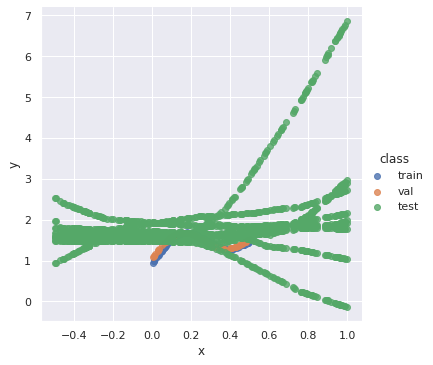

In [13]:
test_x = np.random.rand(200) * 1.5 - 0.5
test_x = test_x.reshape(-1,1)
test_x = torch.Tensor(test_x).to(device)

toy.eval()
# toy.sample()
df = pd.DataFrame({'x':data_x.cpu().numpy().reshape(-1), 'y':data_y.cpu().numpy().reshape(-1)})
df["class"] = "train"
df_ = pd.DataFrame({'x':val_x.cpu().numpy().reshape(-1), 'y':val_y.detach().cpu().numpy().reshape(-1)})
df_["class"] = "val"
df = pd.concat([df,df_])

for _ in range(10):
    test_y = toy(test_x)
    df_ = pd.DataFrame({'x':test_x.cpu().numpy().reshape(-1), 'y':test_y.detach().cpu().numpy().reshape(-1)})
    df_["class"] = "test"
    df = pd.concat([df,df_])
sns.lmplot(x='x',y='y',hue='class', data=df,fit_reg=False)


In [22]:
from scipy.stats import pearsonr
x = np.array(list(range(10)), dtype="float32")
y = x ** 3
np.percentile(x, 100, )

9.0

In [24]:
a = [1,2,3,4]
np.mean(a)

2.5

In [25]:
torch.Tensor([1,2,3]).device

device(type='cpu')